In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import acnportal
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import sys

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json

from acnportal import acnsim
from acnportal import algorithms
from acnportal.acnsim.events import EventQueue
# from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
from utility_functions.signals.tariffs.tou_tariff import TimeOfUseTariff
from acnportal.acnsim.events import GaussianMixtureEvents
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.network import ChargingNetwork
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator
# from acnportal.acnsim import analysis
from utility_functions import analysis
# from modified_evse import *
from acnportal.acnsim.models.evse import get_evse_by_type
# import sqlite3
# from sqlalchemy import create_engine

In [3]:
# This method won't take a evse_per_phase argument
def ev_fleet_level_2_network(transformer_cap=130):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(5)]
    BC_ids = ['BC-{0}'.format(i) for i in range(5)]
    CA_ids = ['CA-{0}'.format(i) for i in range(5)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 415
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 230
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

In [4]:
# How long each time discrete time interval in the simulation should be.
PERIOD = 5  # minutes

# Voltage of the network.
VOLTAGE = 415  # volts      

# Default maximum charging rate for each EV battery.
DEFAULT_BATTERY_POWER = 21 # kW

In [5]:
try:
    from sklearn.mixture import GaussianMixture
except ImportError:
    print("Scikit-learn is not installed. Please install it using: pip install scikit-learn")
    exit()

class NumpyEncoder(json.JSONEncoder):
    """
    Custom JSON encoder for NumPy types.
    This encoder converts NumPy arrays to lists and other NumPy numeric types
    to their standard Python equivalents, making them JSON serializable.
    """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.bool_):
            return bool(obj)
        # Allow the encoder to handle the GaussianMixture object by converting its __dict__
        if isinstance(obj, GaussianMixture):
             return {key: value for key, value in obj.__dict__.items()}
        return super(NumpyEncoder, self).default(obj)

def convert_pickle_to_json(pickle_file_path):
    """
    Loads a pickled object, extracts its attributes into a dictionary,
    and converts the dictionary to a JSON string.

    Args:
        pickle_file_path (str): The path to the .pkl file.

    Returns:
        str: A JSON string representation of the pickled object's data,
             or an error message if the conversion fails.
    """
    try:
        # WORKAROUND: The pickle file was created with an older version of scikit-learn
        # that used the module path 'sklearn.mixture.gaussian_mixture'. Newer versions
        # have refactored this. The line below creates a "fake" module entry that
        # points the old path to the new module location, allowing pickle to load the file.
        sys.modules['sklearn.mixture.gaussian_mixture'] = sklearn.mixture

        # Open the pickle file in binary read mode
        with open(pickle_file_path, 'rb') as f:
            # Load the data from the pickle file. This requires the
            # scikit-learn library to be installed and the GaussianMixture
            # class to be imported.
            data = pickle.load(f)

        # Scikit-learn models and other complex objects are not directly
        # JSON serializable. We can convert the object's attributes
        # to a dictionary to prepare for JSON conversion.
        # The __dict__ attribute holds the object's writable attributes.
        if hasattr(data, '__dict__'):
            # Create a dictionary from the object's attributes
            data_dict = {key: value for key, value in data.__dict__.items()}
        else:
            # If the object has no __dict__, it might be a simple type
            # that json.dumps can handle directly, or we might need
            # a different approach. For this case, we'll try to convert it as is.
            data_dict = data

        # Convert the dictionary to a JSON string using the custom NumpyEncoder
        # The 'indent=4' argument makes the JSON output human-readable.
        json_string = json.dumps(data_dict, cls=NumpyEncoder, indent=4)
        return json_string

    except FileNotFoundError:
        return f"Error: The file '{pickle_file_path}' was not found."
    except pickle.UnpicklingError:
        return f"Error: Could not unpickle the file '{pickle_file_path}'. It may be corrupted or in an incompatible format."
    except Exception as e:
        return f"An unexpected error occurred: {e}"

In [6]:
# Specify the path to your pickle file
file_path = 'data\jpl_weekday_40.pkl'

# Convert the pickle file to a JSON string
json_output = convert_pickle_to_json(file_path)

# Print the resulting JSON string
print(json_output)

# Optionally, save the JSON string to a file
# with open('output.json', 'w') as json_file:
#     json_file.write(json_output)
# print("\nJSON data has been saved to output.json")

{
    "n_components": 40,
    "tol": 0.001,
    "reg_covar": 1e-06,
    "max_iter": 1000,
    "n_init": 25,
    "init_params": "kmeans",
    "random_state": null,
    "warm_start": false,
    "verbose": 0,
    "verbose_interval": 10,
    "covariance_type": "full",
    "weights_init": null,
    "means_init": null,
    "precisions_init": null,
    "converged_": true,
    "weights_": [
        0.025922147836577664,
        0.001485926941776662,
        0.007742360739654906,
        0.01064862392508034,
        0.016248340773010028,
        0.0314786213797282,
        0.028853898525421667,
        0.009097956438618743,
        0.02229798926830542,
        0.06709310085213183,
        0.015598894000317437,
        0.04132346766319137,
        0.03700678395208237,
        0.028491341048672514,
        0.03590069892074091,
        0.003812756332285406,
        0.009640857832097411,
        0.010565216303062766,
        0.00864376136576181,
        0.007265241904662539,
        0.0009033445389

c:\Users\s3955218\Anaconda3\envs\evsim\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### Generate synthetic events for simulation

In [7]:
# Generate synthetic events based on JPL data provided by ACN-Sim.
class CustomUnpicklerJPLdata(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "sklearn.mixture.gaussian_mixture":
            return sklearn.mixture.GaussianMixture
        if name == "GaussianMixture":
            return sklearn.mixture.GaussianMixture
        return super().find_class(module, name)
    
def get_synth_events(sessions_per_day):
    gmm = CustomUnpicklerJPLdata(open('./data/jpl_weekday_40.pkl', "rb")).load()


    # Generate a list of the number of sessions to draw for each day.
    # This generates 30 days of charging demands.
    # num_evs = [0]*2 + [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2 + \
    #           [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2

    # Generate sessions for 1 day (weekdays only)
    num_evs = [0]*2 + [sessions_per_day]*1

    # Note that because we are drawing from a distribution, some sessions will be
    # invalid, we ignore these sessions and remove the corresponding plugin events.
    # gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=0.08334)
    gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=5)

    synth_events = gen.generate_events(num_evs, PERIOD, VOLTAGE, DEFAULT_BATTERY_POWER)
    return synth_events

In [8]:
# 46 EV sessions per weekday
events_46_ev = get_synth_events(46)

In [9]:
# Checking session details
session_copy = deepcopy(events_46_ev)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.arrival, \
          session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

641 session_12 641 720 11.858178321491815 Plugin
648 session_18 648 776 39.35846359922061 Plugin
642 session_27 642 774 8.07394661454528 Plugin
652 session_7 652 761 8.29922504035998 Plugin
652 session_10 652 751 11.741119069644188 Plugin
650 session_6 650 758 8.476213254410228 Plugin
645 session_11 645 756 12.067602342113195 Plugin
654 session_32 654 787 6.853523462725821 Plugin
660 session_1 660 803 0.8013954475672149 Plugin
656 session_39 656 776 14.034256094953406 Plugin
659 session_21 659 771 7.091173036264655 Plugin
665 session_24 665 782 6.432517970573482 Plugin
652 session_5 652 764 8.115271625041066 Plugin
646 session_13 646 782 12.021509227753937 Plugin
675 session_14 675 735 11.31627196335662 Plugin
659 session_31 659 779 51.81788362611431 Plugin
665 session_34 665 761 4.964477742207862 Plugin
670 session_36 670 730 14.155958819484244 Plugin
671 session_38 671 790 15.305248713289949 Plugin
660 session_40 660 765 13.62589323195308 Plugin
665 session_41 665 785 12.965037242415

In [ ]:
session_copy = deepcopy(events_46_ev)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[1])
    # print(session[1].ev._session_id, session[1].ev.arrival, \
    #       session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type, session[1].precedence)

#### Run Simulation with New Equation

In [25]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost_with_pv),
                modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_for_priority_ev, 2),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_without_priority_ev),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6)
               ]

sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=1000, max_recompute=1)

In [27]:
sims = dict()
def run_experiment(alg_name, cap):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """
    # Timezone of the ACN we are using.
    # timezone = pytz.timezone('America/Los_Angeles')
    # Australian timezone for the experiment
    timezone = pytz.timezone('Australia/Melbourne')

    start = timezone.localize(datetime(2026, 1, 2))
    end = timezone.localize(datetime(2026, 1, 2))

    cn = ev_fleet_level_2_network(transformer_cap=cap)

    alg = deepcopy(sch[alg_name])
    alg.max_rate_estimator = algorithms.SimpleRampdown()
    alg.estimate_max_rate = True
    experiment_events = deepcopy(events_46_ev)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = modified_simulator.Simulator(cn, alg, experiment_events, start, period=PERIOD, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    if alg_name == "MPC_Offline":
        alg.register_events(experiment_events)
        alg.solve()
    # if alg_name == "MPC":
    #     sim.high_priority_ev_sessions = ["session_19", "session_7", "session_15", "session_10"]
    # sim.high_priority_ev_sessions = ["session_4", "session_12", "session_2"]
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")

    return sim

In [ ]:
warnings.simplefilter("ignore")

capacities = list(range(130, 160, 10))
alg_names = ["Unctrl", "RR", "LLF", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        try:
            sims[config] = run_experiment(*config)
        except Exception as e:
            print(f"InfeasibilityException: {e}")
            sims[config] = None
            continue

In [ ]:
# result_dir = "results/sims/new_simulation"
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
    
# for config, sim in sims.items():
#     name = "results/sims/new_simulation/{0}-{1}.json.gz".format(*config)
#     if not os.path.exists(name):
#         data = sim.to_json()
#         with gzip.GzipFile(name, 'w') as fout:
#             fout.write(json.dumps(data).encode('utf-8'))

#### Result Analysis

In [ ]:
priority_ev_sessions = ["session_10", 
                        "session_31", 
                        "session_24", 
                        "session_33", 
                        "session_35",
                        "session_4",
                        "session_0",
                        "session_35"]

In [ ]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": "three_phase",
        "Algorithm": config[0],
        "Capacity (kW)": config[1],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Demand met": analysis.proportion_of_demands_met(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[1] * 100,
        "energy_cost": analysis.energy_cost(sim),
        "total_energy_delivered": analysis.total_energy_delivered(sim),
        "Energy Delivered to priority evs (%)": analysis.proportion_of_priority_evs_energy_delivered(sim, priority_ev_sessions),
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))

    return metrics

In [16]:
# filter the sims dict to only include the ones that are not None
sims = {k: v for k, v in sims.items() if v is not None}

In [17]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [18]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Energy Delivered to priority evs (%),Peak (kW),Current Unbalance
0,three_phase,Unctrl,120,100.000,100.000,137.500,50.096,540.105,100.000,165.000,0.341
1,three_phase,RR,120,72.172,69.565,77.308,62.293,389.805,68.886,92.770,0.344
2,three_phase,LLF,120,72.172,69.565,77.308,62.293,389.804,68.886,92.770,0.345
3,three_phase,MPC,120,64.879,34.783,83.875,80.331,350.415,71.762,100.650,0.369
4,three_phase,Unctrl,130,100.000,100.000,126.923,50.096,540.105,100.000,165.000,0.362
5,three_phase,RR,130,72.172,69.565,71.362,62.293,389.805,68.886,92.770,0.352
6,three_phase,LLF,130,72.172,69.565,71.362,62.263,389.804,68.886,92.770,0.346
7,three_phase,MPC,130,65.264,34.783,88.765,80.946,352.495,71.762,115.395,0.365
8,three_phase,Unctrl,140,100.000,100.000,117.857,50.096,540.105,100.000,165.000,0.374
9,three_phase,RR,140,72.172,69.565,66.264,62.293,389.805,68.886,92.770,0.334


In [19]:
for config, sim in sims.items():
    print(config, sim)

('Unctrl', 120) modified_simulator.modified_simulator.Simulator(network=<acnportal.contrib.acnsim.network.stochastic_network.StochasticNetwork object at 0x000001B7DD46C430>, scheduler=<acnportal.algorithms.uncontrolled_charging.UncontrolledCharging object at 0x000001B7F8F89D60>, max_recompute=1, event_queue=<acnportal.acnsim.events.event_queue.EventQueue object at 0x000001B7F8F89640>, start=<datetime.datetime object at 0x000001B7F92D8840>, period=5, signals=<dict object at 0x000001B7F926EB80>, verbose=False, pilot_signals=<numpy.ndarray object at 0x000001B7BCB9B750>, charging_rates=<numpy.ndarray object at 0x000001B7DEA5A6F0>, peak=<numpy.float64 object at 0x000001B7F932B090>, ev_history=<dict object at 0x000001B7F92B1D80>, event_history=<list object at 0x000001B7F92A9E40>, schedule_history=None, _iteration=849, _resolve=False, _last_schedule_update=848)
('RR', 120) modified_simulator.modified_simulator.Simulator(network=<acnportal.contrib.acnsim.network.stochastic_network.StochasticNe

In [20]:
plt.rcParams.update({
    'font.size': 8,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'lines.linewidth': 1.2,
    'patch.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.edgecolor': 'black',
    'legend.framealpha': 1.0
})

In [23]:
def plot_ev_charging(sim, ev, ax, label, label_auto_place=False):
    evse_index = sim.network.station_ids.index(ev.station_id)
    session_len = ev.departure - ev.arrival
    x = [sim.start + timedelta(minutes=5 * ev.arrival) + timedelta(minutes=5*i) for i in range(session_len)]
    
    # Define liner colors for different algorithms
    line_colors = {
        "Unctrl": "#1f77b4",  # blue
        "RR": "#8b12be",      # purple
        "LLF": "#ff7f0e",     # orange
        "MPC": "#2ca02c"      # green
    }

    # label names
    label_names = {
        "Unctrl": "Uncontrolled",
        "RR": "RR",
        "LLF": "LLF",
        "MPC": "MPC_AQ",
    }


    # Use Seaborn to plot the charging rates
    sns.lineplot(x=x, y=sim.charging_rates[evse_index][ev.arrival:ev.departure],
                 drawstyle='steps-post', ax=ax, label=label_names[label], color=line_colors[label], linewidth=1.2)

    # Set grid
    ax.grid(True, alpha=0.3, linewidth=0.5, linestyle='-')
    
    ax.tick_params(axis='both', which='major', labelsize=6, direction='in', 
               top=False, right=False, length=4, width=0.8)
    ax.tick_params(axis='both', which='minor', labelsize=6, direction='in',
                top=False, right=False, length=2, width=0.5) 
    
    if label == "MPC":
        ax.set_xlabel("Time of Day", fontsize=7)

    if label_auto_place:
        ax.legend(bbox_to_anchor=(0.5, 0.95), loc='center', fontsize=6)
    else:
        ax.text(0.02, 0.9, label, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=7)

def plot_profiles(sims, cap, ev, end=None, label_auto_place=False):
    fig, axes = plt.subplots(4, 1, sharey=True, sharex=True, figsize=(3.5, 4.5), dpi=300)

    x_min = sim.start + timedelta(minutes=5 * ev.arrival)
    x_max = end if end is not None else sim.start + timedelta(minutes=5 * ev.departure)
    axes[0].set_xlim(x_min, x_max)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    axes[0].set_ylim(0, 35)
    axes[0].set_yticks([0, 15, 35], fontsize=6)
    
    # plt.subplots_adjust(hspace=.2)
    # Set seaborn style
    sns.set_style("whitegrid", {
        'axes.grid': True,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.3
    })
    
    # Adjust x-position based on figure width (3.5 inches)
    # Use a smaller x value for narrower figures
    x_pos = 0.02 if fig.get_figwidth() > 4 else 0.01
    fig.text(x_pos, 0.55, 'Charging Current (A)', va='center', rotation='vertical', fontsize=7)
    # plt.tight_layout()
    print(ev.session_id)
    for i, alg_name in enumerate(["Unctrl", "RR", "LLF", "MPC"]):
        # label = alg_name if alg_name != "Offline" else "Offline Optimal"
        label = alg_name
        plot_ev_charging(sims[alg_name, cap], ev, axes[i], label=label, label_auto_place=label_auto_place)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].spines['right'].set_visible(True)
        axes[i].spines['top'].set_visible(True)
    return fig

In [21]:
evs = list(sims["LLF", cap].ev_history.values())
print(evs)

[acnportal.acnsim.models.ev.EV(_arrival=632, _departure=692, _session_id=<str object at 0x000001B7F8E681F0>, _station_id=<str object at 0x000001B7FE1D8BF0>, _requested_energy=<numpy.float64 object at 0x000001B7FFB7DB30>, _estimated_departure=692, _battery=<acnportal.acnsim.models.battery.Battery object at 0x000001B7F9504850>, _energy_delivered=<numpy.float64 object at 0x000001B7FFB0B290>, _current_charging_rate=<numpy.float64 object at 0x000001B7FFB0BA90>), acnportal.acnsim.models.ev.EV(_arrival=641, _departure=743, _session_id=<str object at 0x000001B7F8E56E70>, _station_id=<str object at 0x000001B7FE1D89B0>, _requested_energy=<numpy.float64 object at 0x000001B7FFB7D0D0>, _estimated_departure=743, _battery=<acnportal.acnsim.models.battery.Battery object at 0x000001B7F9504820>, _energy_delivered=<numpy.float64 object at 0x000001B7FFB0BB70>, _current_charging_rate=<numpy.float64 object at 0x000001B7FFB0B6F0>), acnportal.acnsim.models.ev.EV(_arrival=645, _departure=759, _session_id=<str 

session_26


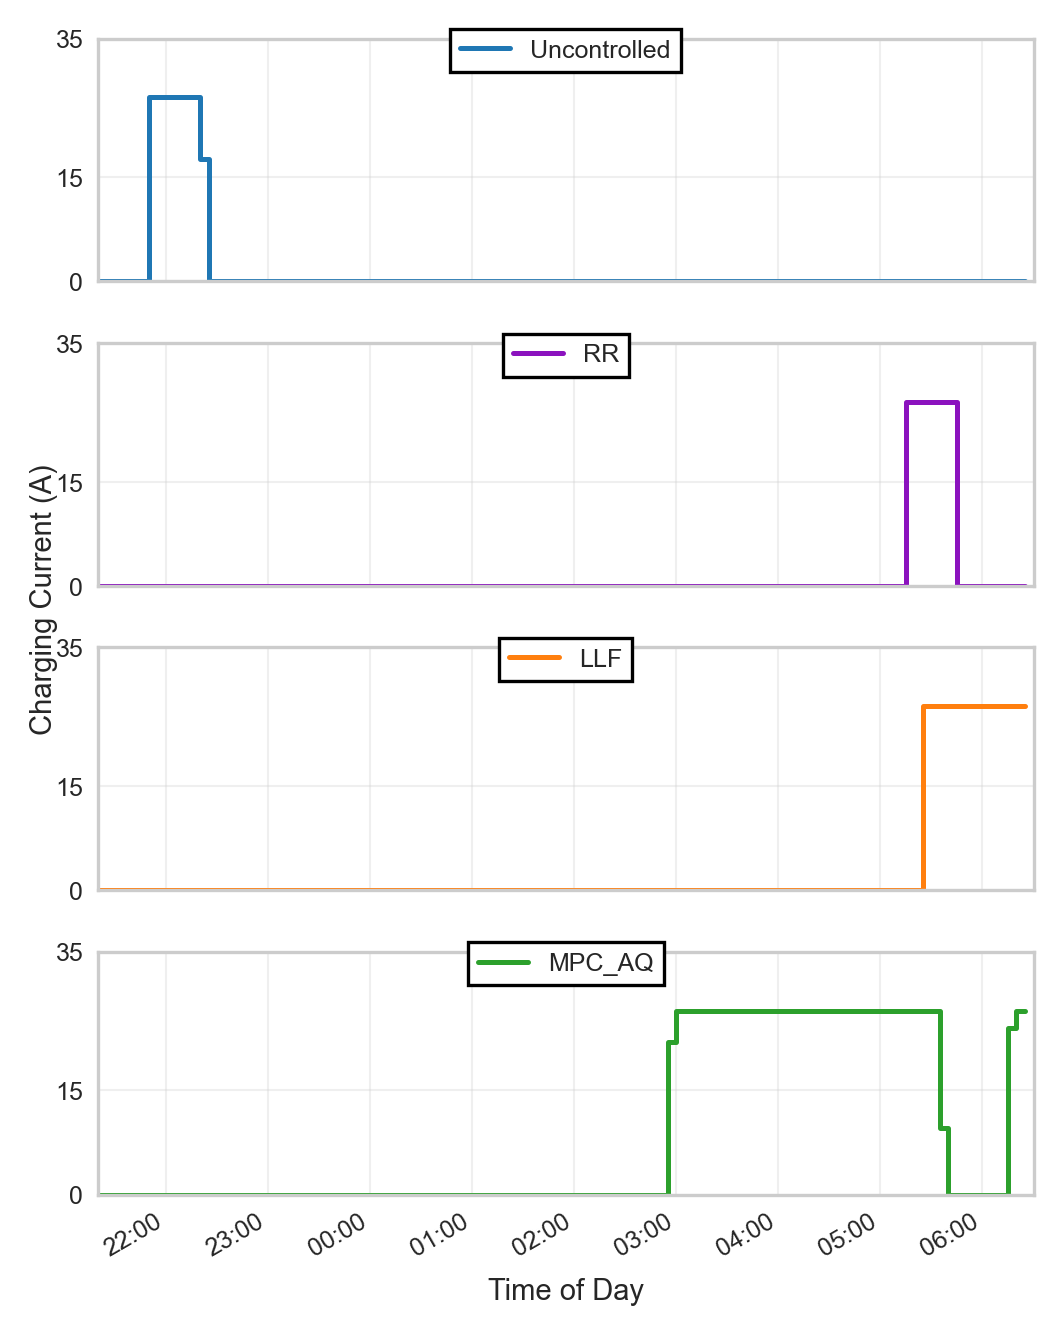

In [31]:
ev = random.choice(list(sims["RR", cap].ev_history.values()))
cap = 140
plot_profiles(sims, cap, ev, label_auto_place=True)

# Saving the plot
plt.tight_layout()
# file_basename = "C:\\Users\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\RQ2\\Simualtion_results\\15evse\generate_charging_schedule"
# plt.savefig(f"{file_basename}.png", dpi=300, bbox_inches='tight')
# print(f"Plot saved as {file_basename}.png")
plt.show()